# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from matplotlib import pyplot as plt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import xgboost as xgb
from sklearn import ensemble as en
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

In [2]:
# Loading Data
data = pd.read_csv( '/work/train.csv')

# 1 Descrição dos dados

In [3]:
df1 = data.copy()

In [4]:
df1.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.172008,2577.05,24196.89636,104.306544,31.038763,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.874152,2465.39,19227.37796,69.858778,36.917093,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.643127,1055.29,42822.28223,134.201478,34.561714,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.141267,703.05,51786.82600,297.350067,31.493561,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.716114,891.29,44626.85346,134.201478,28.028887,2,8,7,24,10,8,20,Sim,Não,Negar


## 1.1 Data Dimensions

In [5]:
df1.shape

(9500, 17)

## 1.2. Data Types

In [6]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.3. Check NA

In [7]:
df1.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.4 Descriptive Statistics

In [8]:
num_attributes = df1.select_dtypes( include={ 'int64', 'float64' } )
cat_attributes = df1.select_dtypes( exclude={ 'int64', 'float64' } )

In [9]:
# Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['atributos', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m

,atributos,min,max,range,media,mediana,std,skew,kurtosis
0,id_cliente,1.000000,1.250000e+04,1.249900e+04,6210.532947,6172.500000,3.603054e+03,0.014114,-1.199109
1,idade,18.000000,8.598000e+03,8.580000e+03,126.398421,38.000000,6.849999e+02,9.092579,87.613308
2,saldo_atual,0.088628,1.602041e+03,1.601952e+03,404.532032,337.169588,2.176853e+02,1.621743,3.104578
3,divida_atual,0.230000,4.998070e+03,4.997840e+03,1437.086420,1175.730000,1.156202e+03,1.187913,0.848447
4,renda_anual,10473.865350,2.327966e+07,2.326918e+07,195037.274234,45991.106000,1.454197e+06,11.874057,149.389202
5,valor_em_investimentos,0.000000,1.000000e+04,1.000000e+04,611.999323,134.201478,2.002338e+03,4.436327,17.868001
6,taxa_utilizacao_credito,20.992914,4.956452e+01,2.857161e+01,32.270823,32.262649,5.105784e+00,0.042483,-0.915879
7,num_emprestimos,0.000000,1.496000e+03,1.496000e+03,10.863684,3.000000,6.255212e+01,16.366227,310.979754
8,num_contas_bancarias,0.000000,1.779000e+03,1.779000e+03,17.552316,6.000000,1.209738e+02,10.877721,123.218353
9,num_cartoes_credito,1.000000,1.479000e+03,1.478000e+03,21.433158,6.000000,1.226709e+02,8.564262,76.794957


Outliers:

- Idade
- Renda anual (23mi ?)
- Número de empréstimos
- Número de contas bancarias
- Número de cartões de crédito
- Número de pagamentos atrasados
- Número de consultas de crédito

# 2 Feature Engineering

In [10]:
df2 = df1.copy()

# 3 Filtragem de variáveis

In [11]:
df3 = df2.copy()

In [12]:
df2.shape

(9500, 17)

In [13]:
df3.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.172008,2577.05,24196.89636,104.306544,31.038763,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.874152,2465.39,19227.37796,69.858778,36.917093,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.643127,1055.29,42822.28223,134.201478,34.561714,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.141267,703.05,51786.82600,297.350067,31.493561,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.716114,891.29,44626.85346,134.201478,28.028887,2,8,7,24,10,8,20,Sim,Não,Negar


In [14]:
# Filtragem de linhas - Idade
df3 = df3[df3['idade'] < 102]
#idade_median = df3['idade'].median()
#df3['idade'] = df3['idade'].apply(lambda x: idade_median if x >=102.0 else x)


# Filtragem de linhas - Numero de emprestimos
#df3 = df3[df3['num_emprestimos'] < 93]
#num_empr_median = df3['num_emprestimos'].median()
#df3['num_emprestimos'] = df3['num_emprestimos'].apply(lambda x: num_empr_median if x >=93 else x) #best


# Filtragem de linhas - Numero de contas bancarias
#df3 = df3[df3['num_contas_bancarias'] < 33]
#num_conta_median = df3['num_contas_bancarias'].median()
#df3['num_contas_bancarias'] = df3['num_contas_bancarias'].apply(lambda x: num_conta_median if x >=33 else x) #best


# Filtragem de linhas - Numero de cartoes                #Boa opção
#df3 = df3[df3['num_cartoes_credito'] < 16]
num_cartao_median = df3['num_cartoes_credito'].median()
df3['num_cartoes_credito'] = df3['num_cartoes_credito'].apply(lambda x: num_cartao_median if x >=16 else x) #best



# Filtragem de linhas - Numero de pagamentos atrasados    # Boa opção
#df3 = df3[df3['num_pgtos_atrasados'] < 85]
num_pgto_median = df3['num_pgtos_atrasados'].median()
df3['num_pgtos_atrasados'] = df3['num_pgtos_atrasados'].apply(lambda x: num_pgto_median if x >=85 else x) # Best


# Filtragem de linhas - Numero de consultas de credito
#df3 = df3[df3['num_consultas_credito'] < 60]
num_consul_median = df3['num_consultas_credito'].median()
df3['num_consultas_credito'] = df3['num_consultas_credito'].apply(lambda x: num_consul_median if x >=60 else x) # Best

In [15]:
df3['num_emprestimos'].max()

1496

In [16]:
df3.shape

(9221, 17)

In [17]:
# Idade: Temos 106 linhas de outliers com idades acima de 101 anos (que seria o limite máximo real)

# Numero de emprestimos: Temos 406 linhas de possiveis outliers com numero de emprestimos a partir de 92

# Numero de contas bancarias: Temos 125 linhas de possiveis outliers com numero de contas a partir de 32

# Numero de cartoes: Temos 212 linhas de possiveis outliers com numero de cartoes a partir de 16

# Numero de pagamentos atrasados: Temos 66 linhas de possiveis outliers com pagamentos a partir de 84

# Numero de consultas de credito: Temos 150 linhas de possiveis outliers com numero de consultas a partir de 59

# 4 Análise exploratória dos dados

In [18]:
df4 = df3.copy()

## 4.1. Ánalise Univariada

### Variável Resposta

In [19]:
le_y = pickle.load(open('/work/le_y.pkl', 'rb'))
aux = df4.copy()

aux['limite_adicional'] = le_y.transform(aux['limite_adicional'])

In [20]:
# 1 = Negar, 0 = Conceder
aux['limite_adicional'].value_counts(normalize=True)

1    0.842425
0    0.157575
Name: limite_adicional, dtype: float64

### Idade

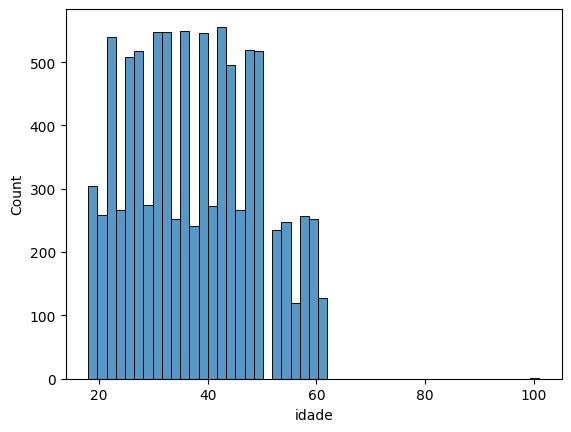

In [21]:
# Dropando outliers
aux1 = df4.loc[ df4['idade'] < 120, : ]

# Plotando gráfico de distribuição
sns.histplot( x='idade', data=aux1 );

### Saldo Atual

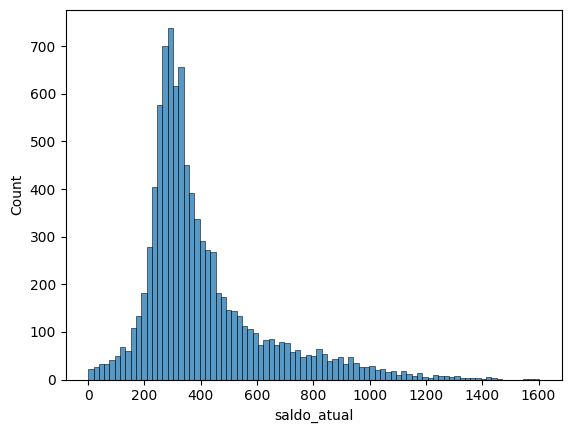

In [22]:
sns.histplot( x='saldo_atual', data=df4 );

### Dívida Atual

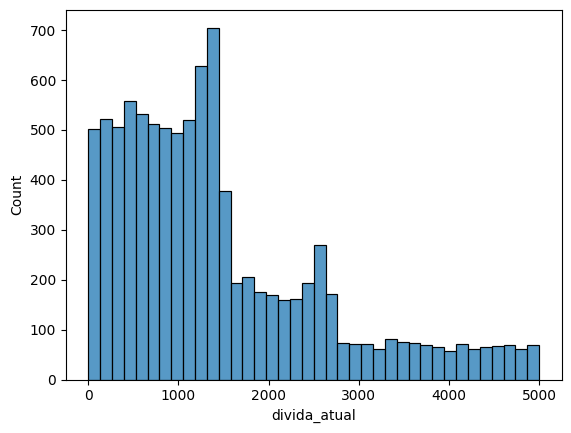

In [23]:
sns.histplot( x='divida_atual', data=df4 );

### Renda Anual

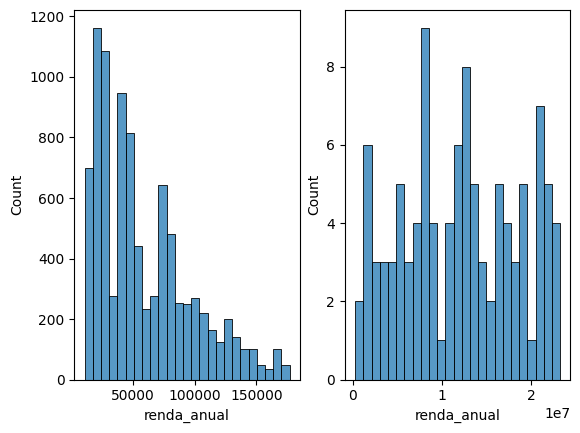

In [24]:
aux1 = df4.loc[ df4['renda_anual'] < 200000, : ]
aux2 = df4.loc[ df4['renda_anual'] > 200000, : ]

plt.subplot( 1, 2, 1 )
sns.histplot( x='renda_anual', data=aux1, bins=25 );

plt.subplot( 1, 2, 2 )
sns.histplot( x='renda_anual', data=aux2, bins=25 );


### Valor em Investimentos

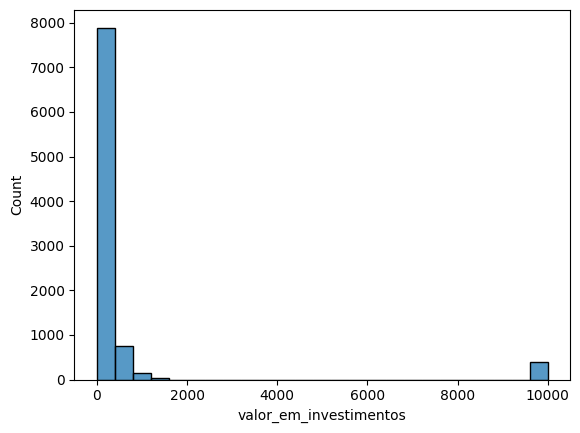

In [25]:
sns.histplot( x='valor_em_investimentos', data=df4, bins=25 );

### Taxa Utilização de Crédito

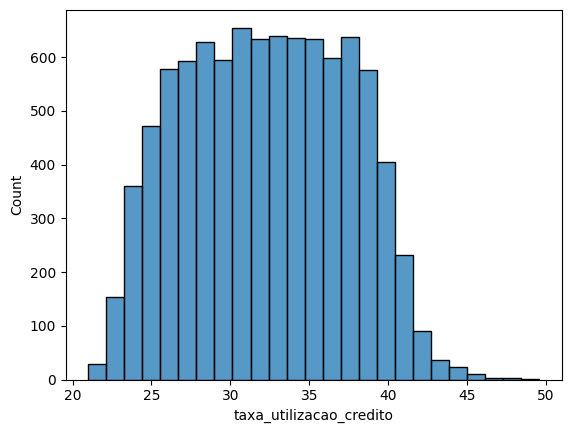

In [26]:
sns.histplot( x='taxa_utilizacao_credito', data=df4, bins=25 );

### Número de empréstimos

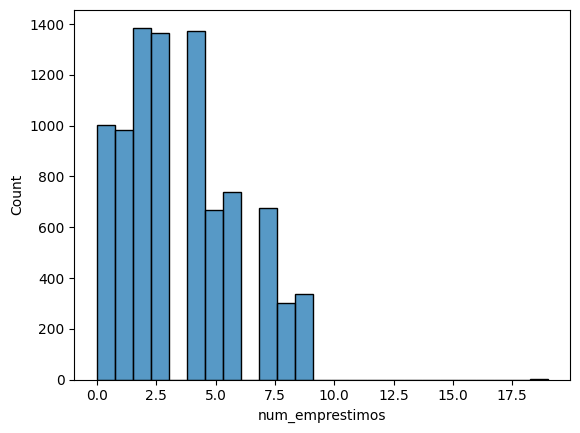

In [27]:
aux1 = df4.loc[ df4['num_emprestimos'] < 50, : ]
sns.histplot( x='num_emprestimos', data=aux1, bins=25 );

### Numero de contas bancarias 

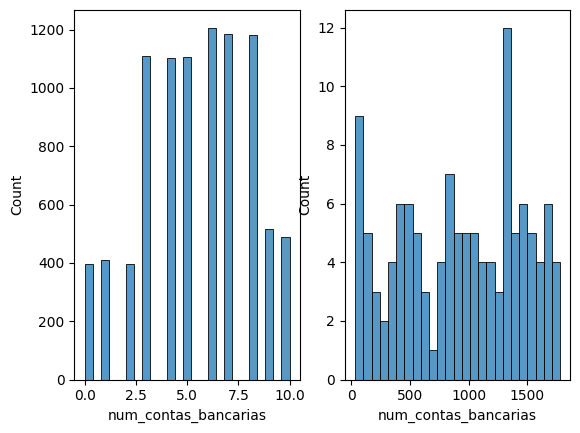

In [28]:
aux1 = df4.loc[ df4['num_contas_bancarias'] < 30, : ]
aux2 = df4.loc[ df4['num_contas_bancarias'] > 30, : ]

plt.subplot( 1, 2, 1 )
sns.histplot( x='num_contas_bancarias', data=aux1, bins=25 );

plt.subplot( 1, 2, 2 )
sns.histplot( x='num_contas_bancarias', data=aux2, bins=25 );

### Numero de cartões de crédito

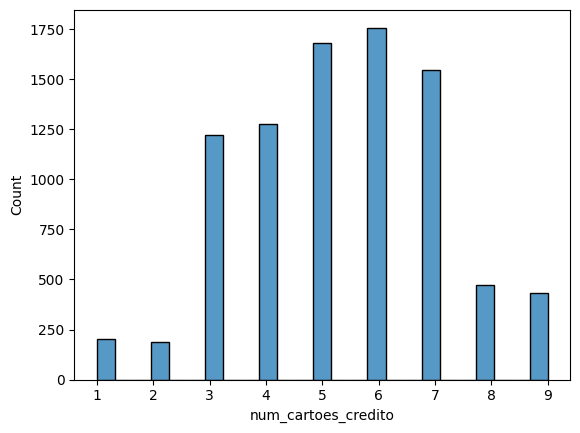

In [29]:
aux1 = df4.loc[ df4['num_cartoes_credito'] < 10, : ]
aux2 = df4.loc[ df4['num_cartoes_credito'] > 10, : ]

sns.histplot( x='num_cartoes_credito', data=aux1, bins=25 );

### Dias Atraso da Data de Vencimento

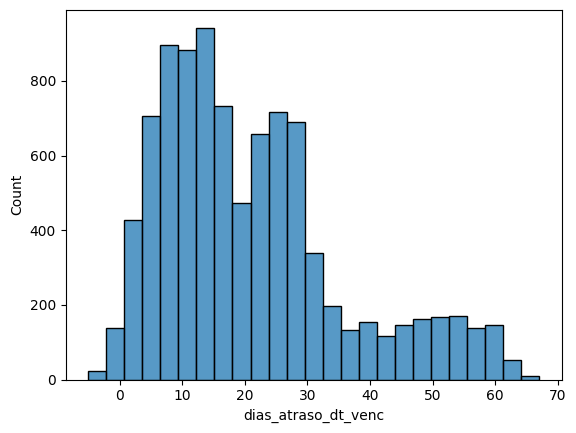

In [30]:
sns.histplot( x='dias_atraso_dt_venc', data=df4, bins=25 );

### Numero de pagamentos atrasados

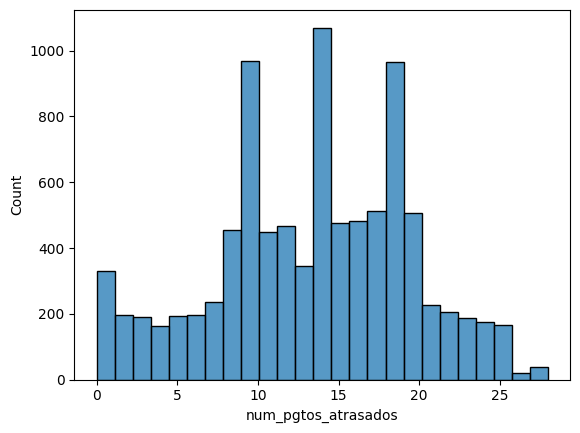

In [31]:
aux1 = df4.loc[ df4['num_pgtos_atrasados'] < 30, : ]
aux2 = df4.loc[ df4['num_pgtos_atrasados'] > 30, : ]

sns.histplot( x='num_pgtos_atrasados', data=aux1, bins=25 );


### Numero de consultas de crédito

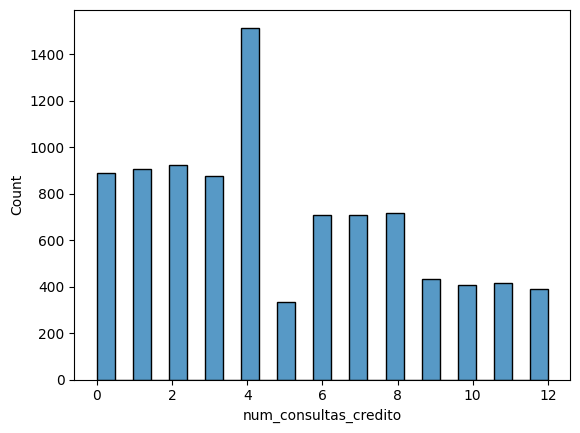

In [32]:
aux1 = df4.loc[ df4['num_consultas_credito'] < 30, : ]
aux2 = df4.loc[ df4['num_consultas_credito'] > 30, : ]
sns.histplot( x='num_consultas_credito', data=aux1, bins=25 );

### Taxa de Juros

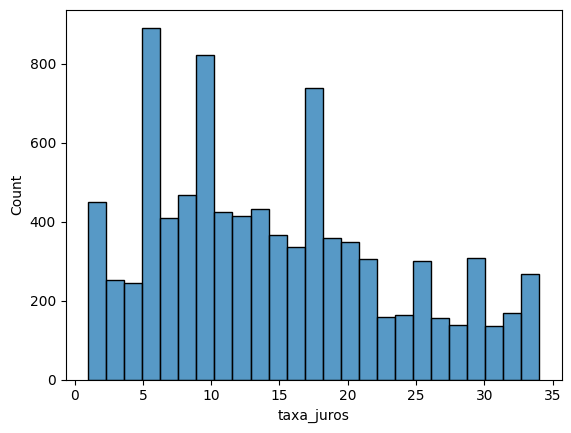

In [33]:
aux1 = df4.loc[ df4['taxa_juros'] < 50, : ]
aux2 = df4.loc[ df4['taxa_juros'] > 50, : ]

sns.histplot( x='taxa_juros', data=aux1, bins=25 );

In [34]:
df4.columns

Index(['id_cliente', 'idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional'],
      dtype='object')

## 4.2 Ánalise Bivariada

### Idade

In [35]:
# Agrupando as idades blocos
df4['idade_agrupada'] = df4['idade'].apply( lambda x: 1 if x < 26 else
                                                               2 if ( 26 >= x < 34 ) else
                                                               3 if ( 34 >= x < 42 ) else
                                                               4 if ( 42 >= x < 50 ) else
                                                               5 if ( 50 >= x < 58 ) else
                                                               6 if ( 58 >= x < 64 ) else
                                                               7)


# Plotando o número de negações por grupo
aux1 = df4[['idade_agrupada', 'limite_adicional']].groupby( 'idade_agrupada' ).sum().reset_index()
#sns.barplot(x='idade_agrupada', y='limite_adicional', data=aux1);

### Saldo Atual

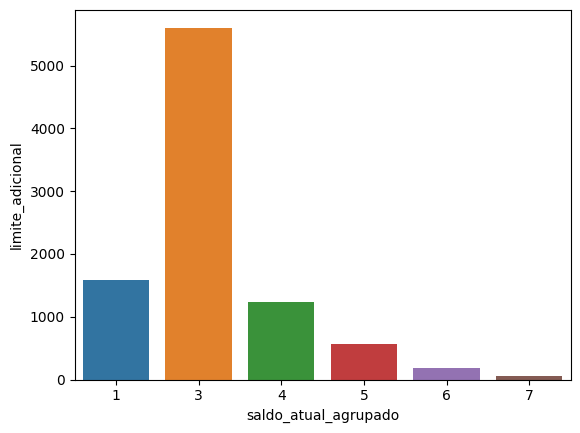

In [36]:
# Agrupando as idades blocos
df4['saldo_atual_agrupado'] = df4['saldo_atual'].apply( lambda x: 1 if x < 250 else
                                                               2 if ( 250 >= x < 500 ) else
                                                               3 if ( 500 >= x < 750 ) else
                                                               4 if ( 750 >= x < 1000 ) else
                                                               5 if ( 1000 >= x < 1250 ) else
                                                               6 if ( 1250 >= x < 1500 ) else
                                                               7)


# Plotando o número de negações por grupo
aux1 = df4[['saldo_atual_agrupado','limite_adicional']].groupby( 'saldo_atual_agrupado' ).count().reset_index()
sns.barplot(x='saldo_atual_agrupado', y='limite_adicional', data=aux1);

# 5 Preparação dos dados

In [162]:
df5 = df3.copy()

In [44]:
df5.columns

Index(['id_cliente', 'idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional'],
      dtype='object')

In [163]:
X = df5.drop(columns=['id_cliente', 'limite_adicional'])
y = df5['limite_adicional']

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print(f'X train shape: {x_train.shape}')
print(f'X test shape: {x_test.shape}')
print(f'y train shape: {y_train.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (7376, 15)
X test shape: (1845, 15)
y train shape: (7376,)
y test shape: (1845,)


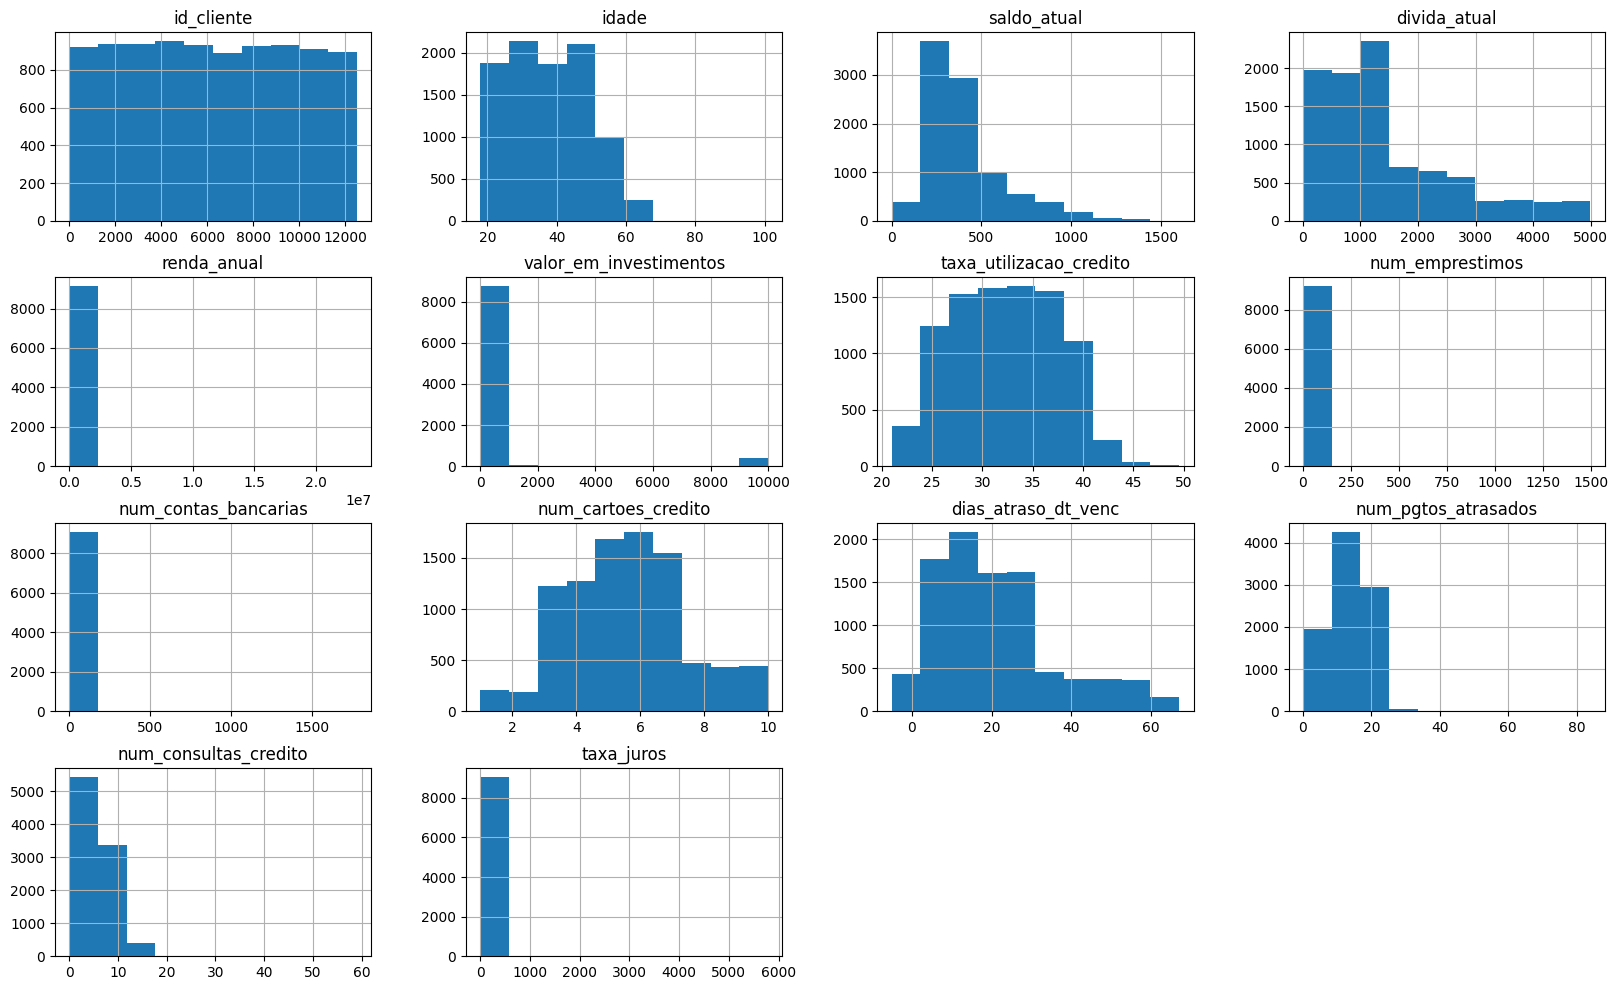

In [40]:
df5.hist(figsize=(20, 12));

#saldo atual, dias atraso dt venc = log

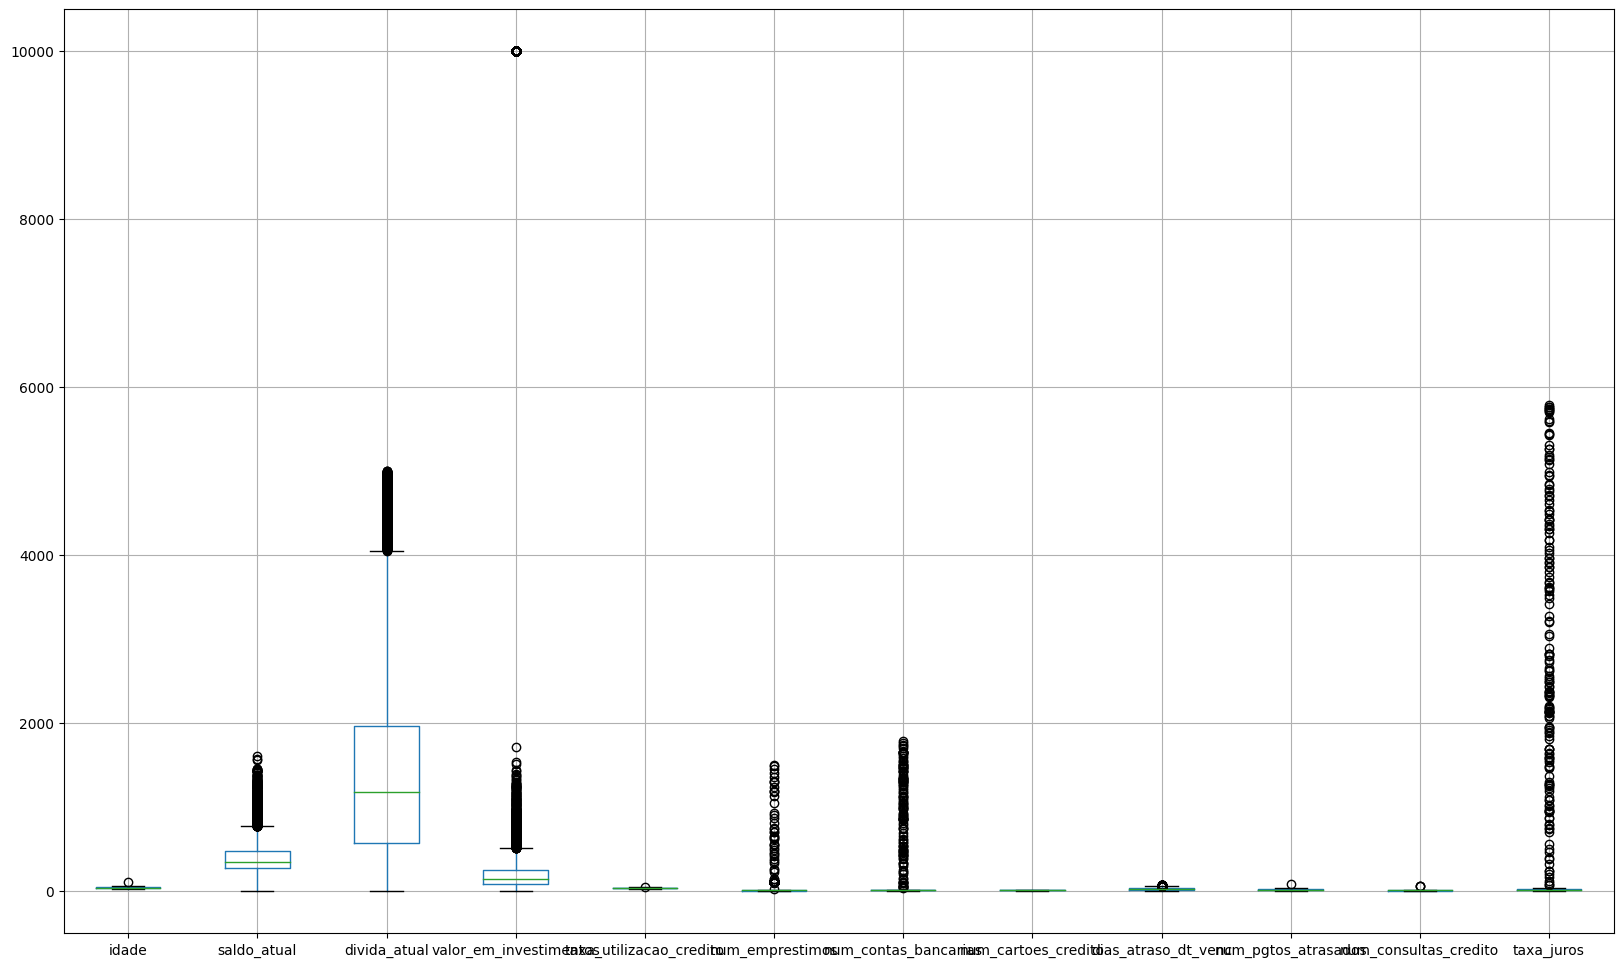

In [41]:
df5.drop(columns=['id_cliente', 'renda_anual']).boxplot(figsize=(20, 12));

# 5.1 Rescaling

In [42]:
x_train.columns

Index(['idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp'],
      dtype='object')

In [43]:
ss = pp.StandardScaler()
rs = pp.MinMaxScaler()

rs.fit(x_train[['idade']])

x_train['idade'] = rs.transform(x_train[['idade']])
df_val['idade'] = rs.transform(df_val[['idade']])

ss.fit(x_train[['saldo_atual']])

x_train['saldo_atual'] = ss.transform(x_train[['saldo_atual']])
df_val['saldo_atual'] = ss.transform(df_val[['saldo_atual']])


rs.fit(x_train[['divida_atual']])

x_train['divida_atual'] = rs.transform(x_train[['divida_atual']])
df_val['divida_atual'] = rs.transform(df_val[['divida_atual']])


rs.fit(x_train[['renda_anual']])

x_train['renda_anual'] = rs.transform(x_train[['renda_anual']])
df_val['renda_anual'] = rs.transform(df_val[['renda_anual']])


rs.fit(x_train[['valor_em_investimentos']])

x_train['valor_em_investimentos'] = rs.transform(x_train[['valor_em_investimentos']])
df_val['valor_em_investimentos'] = rs.transform(df_val[['valor_em_investimentos']])


rs.fit(x_train[['taxa_utilizacao_credito']])

x_train['taxa_utilizacao_credito'] = rs.transform(x_train[['taxa_utilizacao_credito']])
df_val['taxa_utilizacao_credito'] = rs.transform(df_val[['taxa_utilizacao_credito']])


rs.fit(x_train[['num_emprestimos']])

x_train['num_emprestimos'] = rs.transform(x_train[['num_emprestimos']])
df_val['num_emprestimos'] = rs.transform(df_val[['num_emprestimos']])


rs.fit(x_train[['num_contas_bancarias']])

x_train['num_contas_bancarias'] = rs.transform(x_train[['num_contas_bancarias']])
df_val['num_contas_bancarias'] = rs.transform(df_val[['num_contas_bancarias']])


rs.fit(x_train[['num_cartoes_credito']])

x_train['num_cartoes_credito'] = rs.transform(x_train[['num_cartoes_credito']])
df_val['num_cartoes_credito'] = rs.transform(df_val[['num_cartoes_credito']])


ss.fit(x_train[['dias_atraso_dt_venc']])

x_train['dias_atraso_dt_venc'] = ss.transform(x_train[['dias_atraso_dt_venc']])
df_val['dias_atraso_dt_venc'] = ss.transform(df_val[['dias_atraso_dt_venc']])


rs.fit(x_train[['num_pgtos_atrasados']])

x_train['num_pgtos_atrasados'] = rs.transform(x_train[['num_pgtos_atrasados']])
df_val['num_pgtos_atrasados'] = rs.transform(df_val[['num_pgtos_atrasados']])


rs.fit(x_train[['num_consultas_credito']])

x_train['num_consultas_credito'] = rs.transform(x_train[['num_consultas_credito']])
df_val['num_consultas_credito'] = rs.transform(df_val[['num_consultas_credito']])


rs.fit(x_train[['taxa_juros']])

x_train['taxa_juros'] = rs.transform(x_train[['taxa_juros']])
df_val['taxa_juros'] = rs.transform(df_val[['taxa_juros']])

NameError: name 'df_val' is not defined

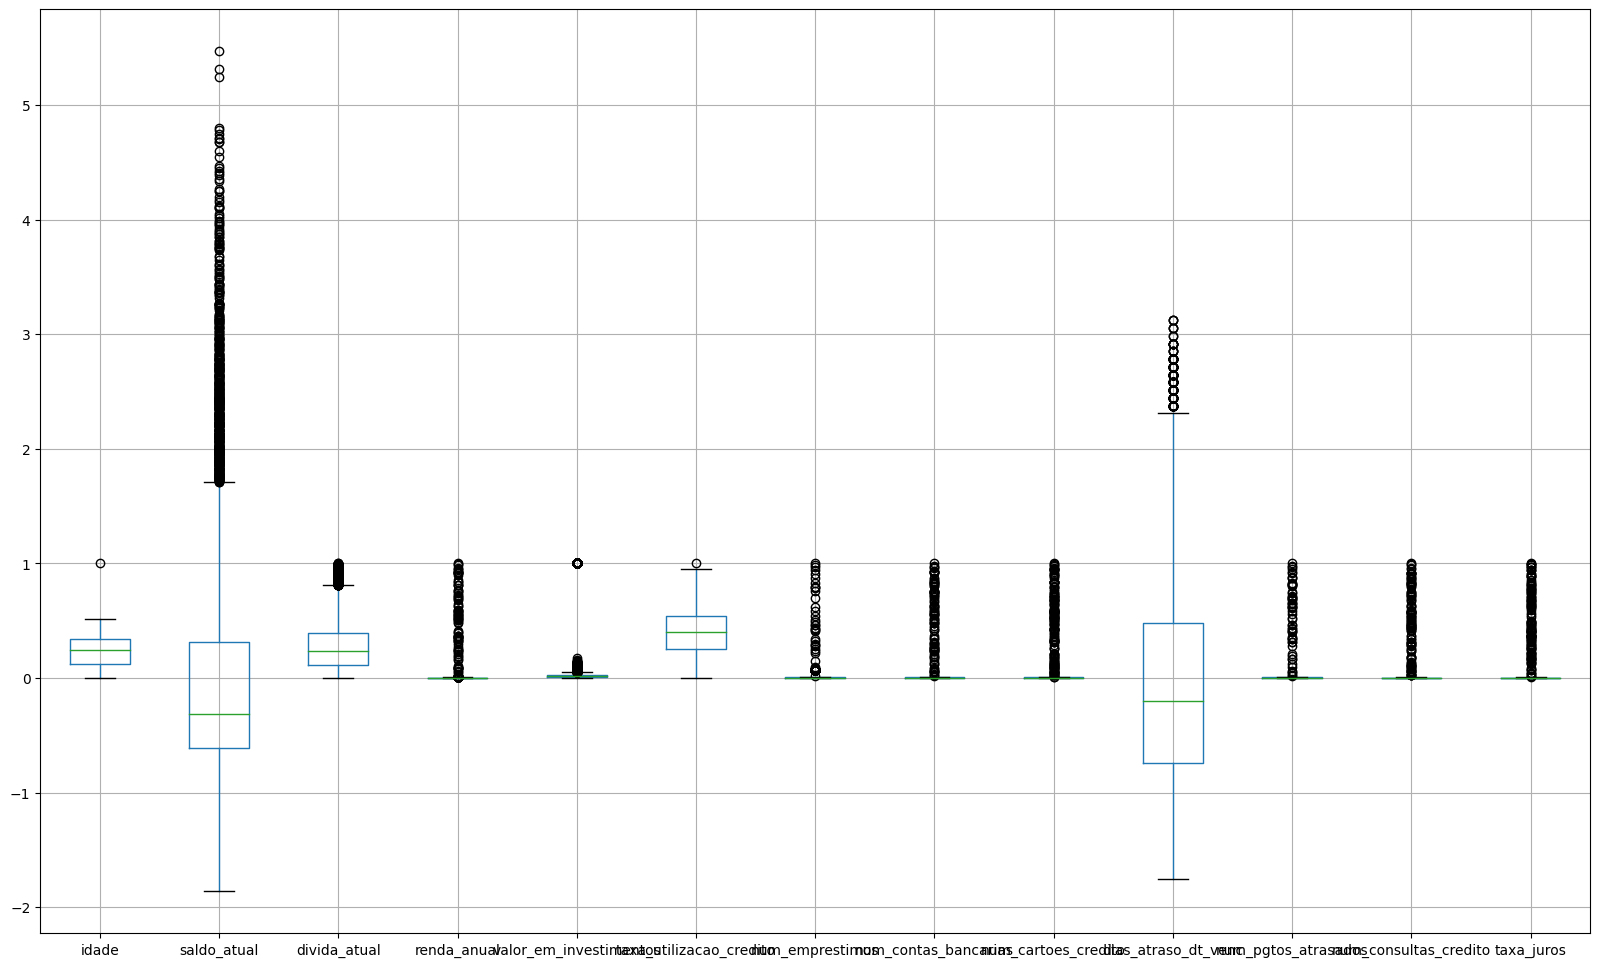

In [ ]:
x_train.boxplot(figsize=(20, 12));

# 5.2 Transformação

In [164]:
# label Encoder

le = pp.LabelEncoder()

# Variavel preditora
le.fit(y_train)
pickle.dump(le, open('/work/le_y.pkl', 'wb'))

y_train = le.transform(y_train)
y_test = le.transform(y_test)


# Investe exterior
le.fit(x_train['investe_exterior'])
pickle.dump(le, open('/work/le_investe_exterior.pkl', 'wb'))

x_train['investe_exterior'] = le.transform(x_train['investe_exterior'])
x_test['investe_exterior'] = le.transform(x_test['investe_exterior'])


# Pessoa politica exposta
le.fit(x_train['pessoa_polit_exp'])
pickle.dump(le, open('/work/pessoa_polit_exp.pkl', 'wb'))

x_train['pessoa_polit_exp'] = le.transform(x_train['pessoa_polit_exp'])
x_test['pessoa_polit_exp'] = le.transform(x_test['pessoa_polit_exp'])


# One Hot Encoding
# x_train = pd.get_dummies(x_train, prefix=['investe_exterior'], columns=['investe_exterior'])
# x_test = pd.get_dummies(x_test, prefix=['investe_exterior'], columns=['investe_exterior'])

# x_train = pd.get_dummies(x_train, prefix=['pessoa_polit_exp'], columns=['pessoa_polit_exp'])
# x_test = pd.get_dummies(x_test, prefix=['pessoa_polit_exp'], columns=['pessoa_polit_exp'])


# Frequency
# fe_investe_exterior = x_train.groupby('investe_exterior').size()/len(x_train)
# x_train.loc[:, 'investe_exterior'] = x_train['investe_exterior'].map(fe_investe_exterior)
# x_test.loc[:, 'investe_exterior'] = x_test['investe_exterior'].map(fe_investe_exterior)

# fe_pessoa_polit_exp = x_train.groupby('pessoa_polit_exp').size()/len(x_train)
# x_train.loc[:, 'pessoa_polit_exp'] = x_train['pessoa_polit_exp'].map(fe_pessoa_polit_exp)
# x_test.loc[:, 'pessoa_polit_exp'] = x_test['pessoa_polit_exp'].map(fe_pessoa_polit_exp)


# Target

# x_train['limite_adicional'] = le.transform(x_train['limite_adicional'])
# te_investe_exterior = x_train.groupby('investe_exterior')['limite_adicional'].mean()
# x_train.loc[:, 'investe_exterior'] = x_train['investe_exterior'].map(te_investe_exterior)
# x_test.loc[:, 'investe_exterior'] = x_test['investe_exterior'].map(te_investe_exterior)

# te_investe_exterior = x_train.groupby('pessoa_polit_exp')['limite_adicional'].mean()
# x_train.loc[:, 'pessoa_polit_exp'] = x_train['pessoa_polit_exp'].map(te_investe_exterior)
# x_test.loc[:, 'pessoa_polit_exp'] = x_test['pessoa_polit_exp'].map(te_investe_exterior)


# x_train = x_train.drop(columns=['limite_adicional'])
# x_test = x_test.drop(columns=['limite_adicional'])

# 6 Feature Selection

# 7 ML Modeling

# 7.1 Extra Trees

In [166]:
et_model = en.ExtraTreesClassifier(random_state=42).fit(x_train, y_train)

y_hat = et_model.predict(x_test)

f1_score(y_test, y_hat)

0.9343558282208589

# 7.2 Random Forest

In [167]:
rf_model = en.RandomForestClassifier(random_state=42).fit(x_train, y_train)

y_hat = rf_model.predict(x_test)

f1_score(y_test, y_hat)

0.9352740786621244

# 7.3 XGBoost

In [168]:
xgb_model = xgb.XGBClassifier(random_state=42).fit(x_train, y_train)

y_hat = xgb_model.predict(x_test)

f1_score(y_test, y_hat)

0.9289514866979657

# 7.4 LightBGM

In [ ]:
# lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1).fit(x_train, y_train)

# y_hat = lgbm_model.predict(x_test)

# f1_score(y_test, y_hat)

KeyboardInterrupt: 

# 8 Hyper Parameter Fine Tunning

# 9 Test data

In [169]:
df_val_raw = pd.read_csv('/work/test.csv', low_memory=False)

In [72]:
df_val_raw.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
dtype: int64

In [170]:
df_val = df_val_raw.drop(columns=['id_cliente']).copy()

In [171]:
# Filtragem de linhas - Numero de cartoes
num_cartao_median = df_val['num_cartoes_credito'].median()
df_val['num_cartoes_credito'] = df_val['num_cartoes_credito'].apply(lambda x: num_cartao_median if x >=16 else x)

# Filtragem de linhas - Numero de pagamentos atrasados
num_pgto_median = df_val['num_pgtos_atrasados'].median()
df_val['num_pgtos_atrasados'] = df_val['num_pgtos_atrasados'].apply(lambda x: num_pgto_median if x >=85 else x)

# Filtragem de linhas - Numero de consultas de credito
num_consul_median = df3['num_consultas_credito'].median()
df3['num_consultas_credito'] = df3['num_consultas_credito'].apply(lambda x: num_consul_median if x >=60 else x)

In [ ]:
le_y = pickle.load(open('/work/le_y.pkl', 'rb'))
le_investe_exterior = pickle.load(open('/work/le_investe_exterior.pkl', 'rb'))
le_pessoa_polit_exp = pickle.load(open('/work/pessoa_polit_exp.pkl', 'rb'))

df_val['investe_exterior'] = le_investe_exterior.transform(df_val['investe_exterior'])
df_val['pessoa_polit_exp'] = le_pessoa_polit_exp.transform(df_val['pessoa_polit_exp'])

In [173]:
df_val.shape

(3000, 15)

In [174]:
y_val = rf_model.predict(df_val)
df_val_raw['limite_adicional'] = y_val

In [175]:
df_val_raw['limite_adicional'] = le_y.inverse_transform(df_val_raw['limite_adicional'].values)

In [111]:
df_val_raw.columns

Index(['id_cliente', 'idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp', 'limite_adicional'],
      dtype='object')

In [176]:
df_val_raw = df_val_raw.drop(columns=['idade', 'saldo_atual', 'divida_atual', 'renda_anual',
       'valor_em_investimentos', 'taxa_utilizacao_credito', 'num_emprestimos',
       'num_contas_bancarias', 'num_cartoes_credito', 'dias_atraso_dt_venc',
       'num_pgtos_atrasados', 'num_consultas_credito', 'taxa_juros',
       'investe_exterior', 'pessoa_polit_exp'])

df_val_raw.head()

,id_cliente,limite_adicional
0,2,Conceder
1,5,Negar
2,6,Negar
3,8,Negar
4,10,Conceder


In [177]:
df_val_raw.to_csv('/work/submit9.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=104b8296-2d41-4515-8c24-57b523e008af' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>